In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("HackathonForecast") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

print("SparkSession creada exitosamente!")

Error: Se ha producido un error de enlace al cargar la clase principal org.apache.spark.launcher.Main
	java.lang.UnsupportedClassVersionError: org/apache/spark/launcher/Main has been compiled by a more recent version of the Java Runtime (class file version 61.0), this version of the Java Runtime only recognizes class file versions up to 55.0
/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/bin/spark-class: l√≠nea 97: CMD: sub√≠ndice de matriz incorrecto


PySparkRuntimeError: [JAVA_GATEWAY_EXITED] Java gateway process exited before sending its port number.

In [ ]:
base_path = "/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/"
path_produtos = f"{base_path}productos"
path_transacoes = f"{base_path}transacoes"
path_pdvs = f"{base_path}pdvs"

# Carga de los DataFrames
df_produtos = spark.read.parquet(path_produtos)
df_transacoes = spark.read.parquet(path_transacoes)
df_pdvs = spark.read.parquet(path_pdvs)

# Renombrar columnas para claridad y consistencia en los joins
df_transacoes = df_transacoes.withColumnRenamed("internal_store_id", "pdv") \
                             .withColumnRenamed("internal_product_id", "produto")

# Verificar que los datos se cargaron correctamente
print("--- Datos de Productos ---")
df_produtos.show(5)

print("--- Datos de Transacciones ---")
df_transacoes.show(5)

print("--- Datos de PDVs ---")
df_pdvs.show(5)

--- Datos de Productos ---
+-------------------+-----------------+--------------------+-----------------+-------------+-------------------+--------------------+--------------------+
|            produto|        categoria|           descricao|            tipos|        label|       subcategoria|               marca|          fabricante|
+-------------------+-----------------+--------------------+-----------------+-------------+-------------------+--------------------+--------------------+
|2282334733936076502|Distilled Spirits|JOSEPH CARTRON CA...|Distilled Spirits|         Core|Liqueurs & Cordials| Joseph Cartron Cafe|            Spiribam|
|6091840953834683482|Distilled Spirits|SPRINGBANK 18 YEA...|Distilled Spirits|    Specialty|      Scotch Whisky|Springbank 18 Yea...|Pacific Edge Wine...|
|1968645851245092408|Distilled Spirits|J BRANDT TRIPLE S...|Distilled Spirits|Private Label|Liqueurs & Cordials| J Brandt Triple Sec|     Sazerac Spirits|
| 994706710729219179|            Draft|REFO

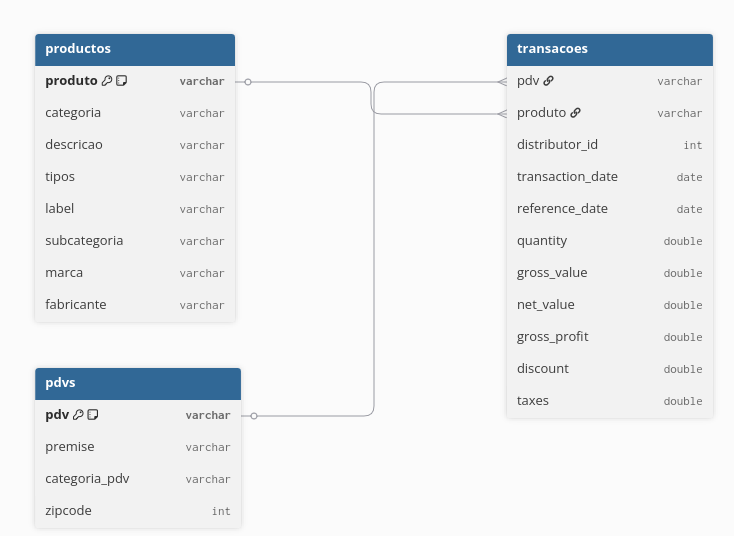

In [ ]:
from pyspark.sql.functions import col, count, when, isnull, countDistinct, upper, regexp_replace
from pyspark.sql.types import StringType

# --- 1. Uni√≥n de las tablas ---
print("## 1. Uniendo las tres tablas...")
df_full = df_transacoes.join(df_produtos, "produto", "left") \
                       .join(df_pdvs, "pdv", "left") \
                       .cache()

total_rows = df_full.count()
print(f"La tabla combinada 'df_full' tiene {total_rows} filas.")



# --- 2. Porcentaje de valores nulos por columna ---
print("\n## 2. Porcentaje de valores nulos por columna (antes de la limpieza):")
df_full.select([
    (count(when(isnull(c), c)) / total_rows * 100).alias(c)
    for c in df_full.columns
]).show()



# --- 3. Limpieza de columnas de texto ---
print("\n## 3. Limpiando columnas de texto (may√∫sculas y sin espacios)...")
# Identificar columnas que son de tipo string
string_columns = [f.name for f in df_full.schema.fields if isinstance(f.dataType, StringType)]

# Crear un nuevo DataFrame para las transformaciones
df_cleaned = df_full

for column_name in string_columns:
    # Aplicar la transformaci√≥n: convertir a may√∫sculas y remover TODOS los espacios
    df_cleaned = df_cleaned.withColumn(
        column_name,
        regexp_replace(upper(col(column_name)), "\\s+", "")
    )

print("Columnas de texto transformadas. Mostrando una muestra del resultado:")
df_cleaned.select(string_columns).show(5, truncate=False)

df_full.unpersist()

## 1. Uniendo las tres tablas...
La tabla combinada 'df_full' tiene 6560698 filas.

## 2. Porcentaje de valores nulos por columna (antes de la limpieza):


25/09/15 19:59:34 WARN CacheManager: Asked to cache already cached data.


+---+-------+--------------+----------------+--------------+--------+-----------+---------+------------+--------+-----+---------+---------+-----+----------------+------------------+-----+----------+------------------+------------------+------------------+
|pdv|produto|distributor_id|transaction_date|reference_date|quantity|gross_value|net_value|gross_profit|discount|taxes|categoria|descricao|tipos|           label|      subcategoria|marca|fabricante|           premise|     categoria_pdv|           zipcode|
+---+-------+--------------+----------------+--------------+--------+-----------+---------+------------+--------+-----+---------+---------+-----+----------------+------------------+-----+----------+------------------+------------------+------------------+
|0.0|    0.0|           0.0|             0.0|           0.0|     0.0|        0.0|      0.0|         0.0|     0.0|  0.0|      0.0|      0.0|  0.0|8.03196550123173|0.1571783977863331|  0.0|       0.0|0.6947736353662369|0.6947736353662

DataFrame[pdv: string, produto: string, distributor_id: string, transaction_date: date, reference_date: date, quantity: double, gross_value: double, net_value: double, gross_profit: double, discount: double, taxes: double, categoria: string, descricao: string, tipos: string, label: string, subcategoria: string, marca: string, fabricante: string, premise: string, categoria_pdv: string, zipcode: int]

In [5]:
df_cleaned.printSchema()

root
 |-- pdv: string (nullable = true)
 |-- produto: string (nullable = true)
 |-- distributor_id: string (nullable = true)
 |-- transaction_date: date (nullable = true)
 |-- reference_date: date (nullable = true)
 |-- quantity: double (nullable = true)
 |-- gross_value: double (nullable = true)
 |-- net_value: double (nullable = true)
 |-- gross_profit: double (nullable = true)
 |-- discount: double (nullable = true)
 |-- taxes: double (nullable = true)
 |-- categoria: string (nullable = true)
 |-- descricao: string (nullable = true)
 |-- tipos: string (nullable = true)
 |-- label: string (nullable = true)
 |-- subcategoria: string (nullable = true)
 |-- marca: string (nullable = true)
 |-- fabricante: string (nullable = true)
 |-- premise: string (nullable = true)
 |-- categoria_pdv: string (nullable = true)
 |-- zipcode: integer (nullable = true)



In [ ]:
# Imputar los valores nulos en la columna 'label' con "SEM_LABEL"
df_imputado = df_cleaned.fillna({'label': 'SEM_LABEL'})

# Verifiquemos el resultado
print("Verificando la imputaci√≥n de nulos en la columna 'label'.")

# Contamos cu√°ntas filas tienen ahora "SEM_LABEL"
sem_label_count = df_imputado.filter(col('label') == 'SEM_LABEL').count()
print(f"N√∫mero de filas con 'SEM_LABEL': {sem_label_count}")

# Mostramos una muestra para ver los valores √∫nicos actuales en la columna
print("\nValores √∫nicos en 'label' despu√©s de la imputaci√≥n:")
df_imputado.groupBy('label').count().show()

Verificando la imputaci√≥n de nulos en la columna 'label'.


N√∫mero de filas con 'SEM_LABEL': 526953

Valores √∫nicos en 'label' despu√©s de la imputaci√≥n:


+--------------+-------+
|         label|  count|
+--------------+-------+
|SUMMERSEASONAL|    709|
|  FALLSEASONAL|   5481|
|      CLEARING|    193|
|SPRINGSEASONAL|    364|
|        IN&OUT|  52005|
|          CORE|5262624|
|WINTERSEASONAL|  11307|
|     SPECIALTY|   4785|
|  DISCONTINUED| 630002|
|         OTHER|      3|
|     ALLOCATED|  57936|
|  PRIVATELABEL|   2569|
|      CLOSEOUT|   5520|
|     SEM_LABEL| 526953|
|    SPECIALITY|    247|
+--------------+-------+



/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Generando Gr√°fico 1: Ventas totales por semana...


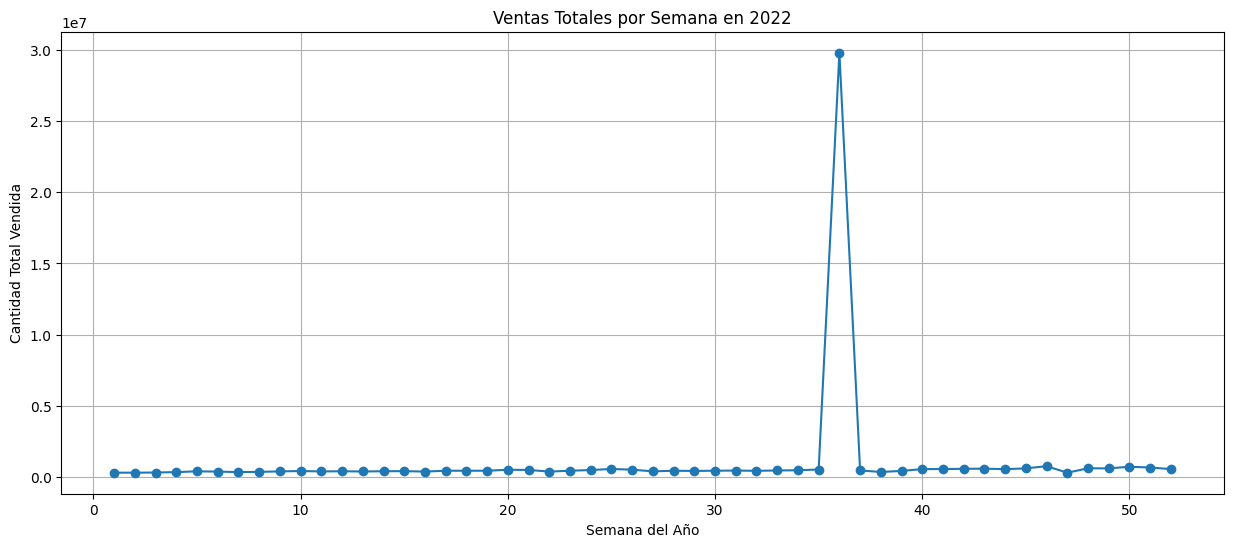

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import weekofyear, month, date_format, sum

# Usar√© 'df_final' como el nombre del DataFrame.
df_para_graficos = df_imputado 

# --- 1. Gr√°fico de L√≠neas de Ventas Semanales ---
print("Generando Gr√°fico 1: Ventas totales por semana...")

ventas_semanales = df_para_graficos.groupBy(weekofyear("transaction_date").alias("semana")) \
    .agg(sum("quantity").alias("total_quantity")) \
    .orderBy("semana") \
    .toPandas()

plt.figure(figsize=(15, 6))
plt.plot(ventas_semanales['semana'], ventas_semanales['total_quantity'], marker='o', linestyle='-')
plt.title('Ventas Totales por Semana en 2022')
plt.xlabel('Semana del A√±o')
plt.ylabel('Cantidad Total Vendida')
plt.grid(True)
plt.show()





In [ ]:
from pyspark.sql.functions import weekofyear, col

# Asumiendo que la semana an√≥mala es la 36 para verificar datos atipicos
SEMANA_ANOMALA = 36

df_anomalia = df_imputado.filter(weekofyear(col("transaction_date")) == SEMANA_ANOMALA)

print(f"Analizando la semana {SEMANA_ANOMALA}...")

# 1. Ver las transacciones m√°s grandes de esa semana
print("\nTop 5 transacciones con mayor cantidad en esa semana:")
df_anomalia.orderBy(col("quantity").desc()).show(5)

# 2. Ver si el problema viene de un solo producto
print("\nTop 5 productos con m√°s ventas en esa semana:")
df_anomalia.groupBy("produto", "descricao").sum("quantity").orderBy(col("sum(quantity)").desc()).show(5, truncate=False)

# 3. Ver si el problema viene de un solo PDV
print("\nTop 5 PDVs con m√°s ventas en esa semana:")
df_anomalia.groupBy("pdv", "categoria_pdv").sum("quantity").orderBy(col("sum(quantity)").desc()).show(5)

Analizando la semana 36...

Top 5 transacciones con mayor cantidad en esa semana:


+-------------------+-------------------+--------------+----------------+--------------+------------------+------------------+------------------+------------------+------------------+-----+----------------+--------------------+----------------+------------+--------------+--------------------+--------------+----------+---------------+-------+
|                pdv|            produto|distributor_id|transaction_date|reference_date|          quantity|       gross_value|         net_value|      gross_profit|          discount|taxes|       categoria|           descricao|           tipos|       label|  subcategoria|               marca|    fabricante|   premise|  categoria_pdv|zipcode|
+-------------------+-------------------+--------------+----------------+--------------+------------------+------------------+------------------+------------------+------------------+-----+----------------+--------------------+----------------+------------+--------------+--------------------+--------------+----

+-------------------+-------------------------------+-----------------+
|produto            |descricao                      |sum(quantity)    |
+-------------------+-------------------------------+-----------------+
|3212701144500706568|SKOLPREMIUMVODKA6/1.75L80PF    |872622.9997992516|
|2995245061726159069|FIREBALL24/375MLPET66PF        |824693.99992311  |
|5854098638082429437|SKOLPREMIUMVODKA24/375ML80PF   |767813.9997800589|
|1380288516179470221|FIREBALL48/200MLPET66PF        |692375.0000576973|
|3620674245436818138|BUFFALOTRACEBOURBON12/750ML90PF|635408.9932726026|
+-------------------+-------------------------------+-----------------+
only showing top 5 rows

Top 5 PDVs con m√°s ventas en esa semana:


+-------------------+--------------+------------------+
|                pdv| categoria_pdv|     sum(quantity)|
+-------------------+--------------+------------------+
|6491855528940268514|PACKAGE/LIQUOR|176202.57088110596|
|3025867614395044464|PACKAGE/LIQUOR|  170252.533326149|
|8723723113467008071|PACKAGE/LIQUOR| 132026.3119776696|
|4304226119364518876|PACKAGE/LIQUOR|130715.99981439114|
|9171644843739559005|PACKAGE/LIQUOR|126486.74994792044|
+-------------------+--------------+------------------+
only showing top 5 rows


/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/tmp/ipykernel_5031/440034828.py:20: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ventas_por_categoria_pdv, x="total_quantity", y="categoria_pdv", palette="viridis")


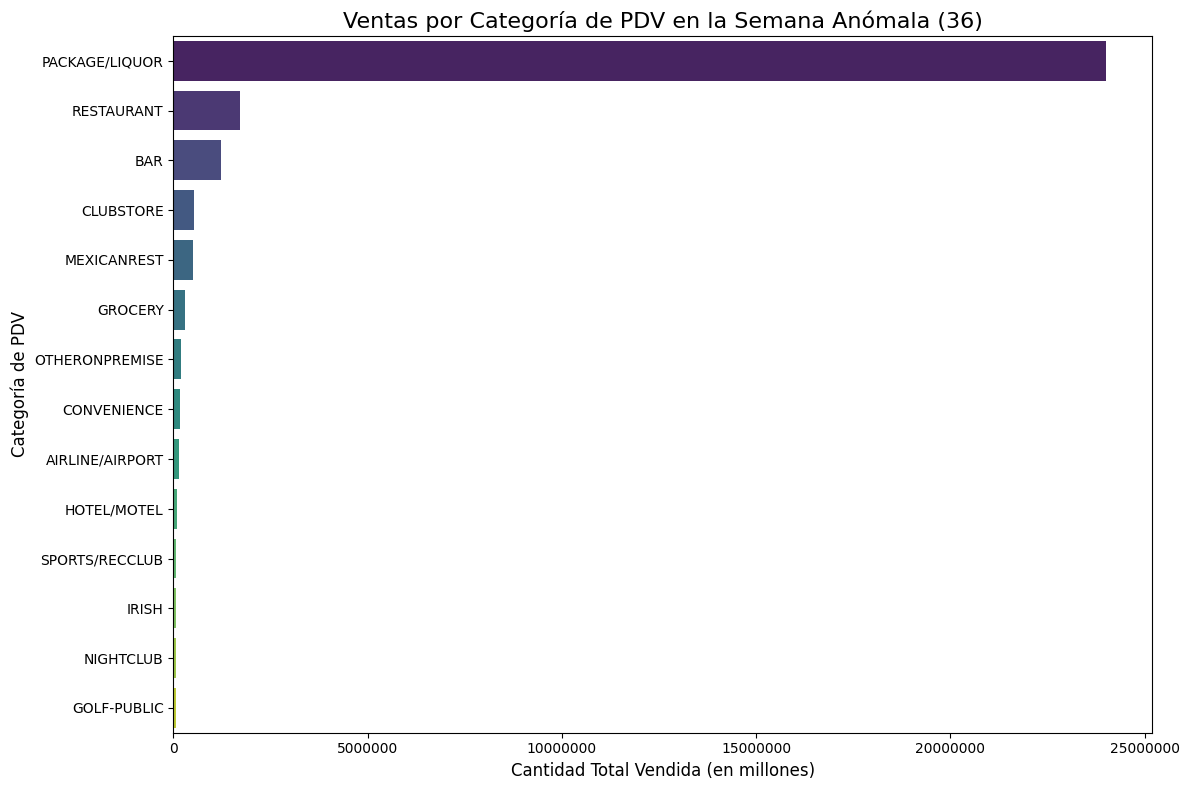

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import weekofyear, col, sum

SEMANA_ANOMALA = 36

# 1. Filtrar los datos para obtener solo la semana 36
df_semana_36 = df_imputado.filter(weekofyear(col("transaction_date")) == SEMANA_ANOMALA)

# 2. Agrupar por categor√≠a de PDV y sumar las cantidades
ventas_por_categoria_pdv = df_semana_36.groupBy("categoria_pdv") \
    .agg(sum("quantity").alias("total_quantity")) \
    .orderBy(col("total_quantity").desc()) \
    .limit(15) \
    .toPandas() # Convertir a Pandas para graficar

# 3. Generar el gr√°fico de barras horizontales
plt.figure(figsize=(12, 8))
sns.barplot(data=ventas_por_categoria_pdv, x="total_quantity", y="categoria_pdv", palette="viridis")

plt.title(f'Ventas por Categor√≠a de PDV en la Semana An√≥mala ({SEMANA_ANOMALA})', fontsize=16)
plt.xlabel('Cantidad Total Vendida (en millones)', fontsize=12)
plt.ylabel('Categor√≠a de PDV', fontsize=12)
plt.ticklabel_format(style='plain', axis='x') # Evitar notaci√≥n cient√≠fica en el eje X
plt.tight_layout() # Ajustar el gr√°fico para que todo sea visible
plt.show()

In [ ]:
from pyspark.sql.functions import col, weekofyear
df_final=df_imputado
# Usamos el operador '!=' para quedarnos con todas las semanas que no sean la 36, 
# esto debido a que esta semana tiene un comportamiento demasiado exorbitante con respecto al resto del a√±o por lo que solo generara ruido en el modelo
df_filtrado_completo = df_final.filter(weekofyear(col("transaction_date")) != 36)

print("Filtrado completo de la semana an√≥mala completado.")
print(f"N√∫mero de filas original: {
df_final.count()
}")
print(f"N√∫mero de filas despu√©s de eliminar toda la Semana 36: {
df_filtrado_completo.count()
}")

Filtrado completo de la semana an√≥mala completado.


N√∫mero de filas original: 6560698


N√∫mero de filas despu√©s de eliminar toda la Semana 36: 6139030


/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Generando Gr√°fico 1: Ventas totales por semana...


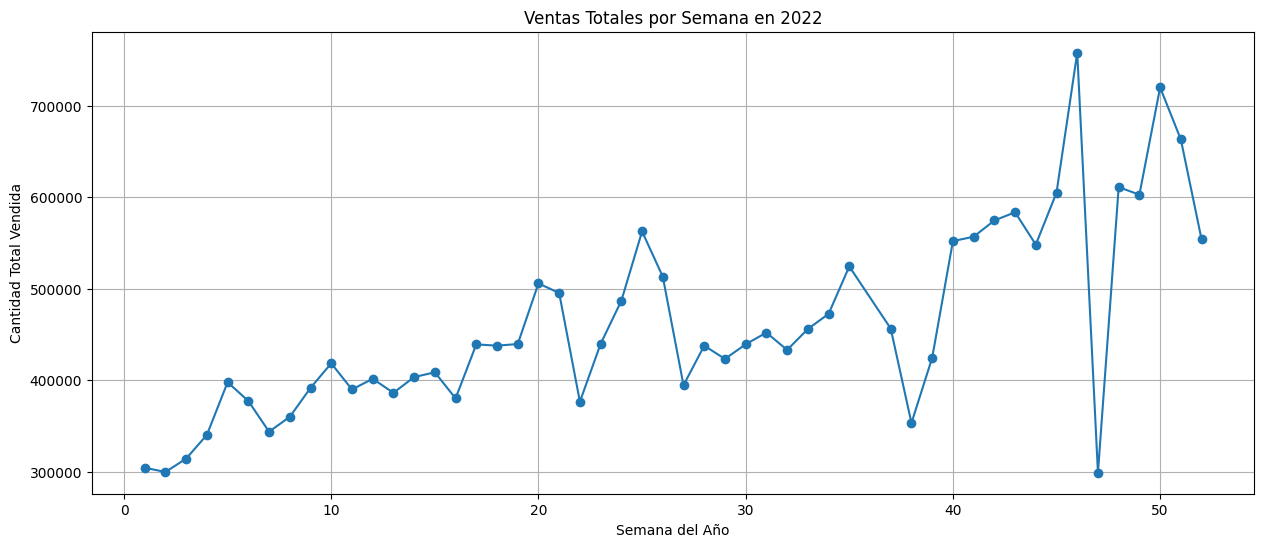

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import weekofyear, month, date_format, sum

df_para_graficos = df_filtrado_completo

# --- 1. Gr√°fico de L√≠neas de Ventas Semanales ---
print("Generando Gr√°fico 1: Ventas totales por semana...")

ventas_semanales = df_para_graficos.groupBy(weekofyear("transaction_date").alias("semana")) \
    .agg(sum("quantity").alias("total_quantity")) \
    .orderBy("semana") \
    .toPandas()

plt.figure(figsize=(15, 6))
plt.plot(ventas_semanales['semana'], ventas_semanales['total_quantity'], marker='o', linestyle='-')
plt.title('Ventas Totales por Semana en 2022')
plt.xlabel('Semana del A√±o')
plt.ylabel('Cantidad Total Vendida')
plt.grid(True)
plt.show()





Generando Gr√°fico 1: Top 10 Categor√≠as de Producto por Ventas...


/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/tmp/ipykernel_5031/2399262109.py:19: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_categorias, x="total_quantity", y="categoria", palette="mako")


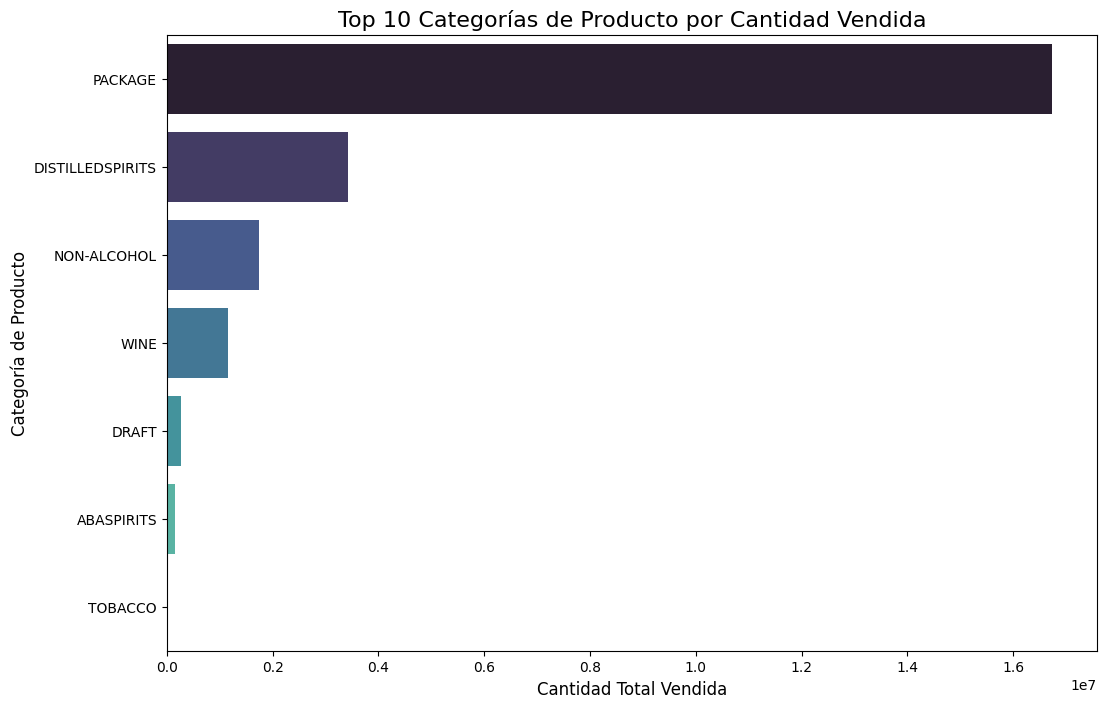

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import sum, col

df_para_analisis = df_filtrado_completo

print("Generando Gr√°fico 1: Top 10 Categor√≠as de Producto por Ventas...")

# Agrupar por categor√≠a, sumar la cantidad, ordenar y tomar el top 10
top_10_categorias = df_para_analisis.groupBy("categoria") \
    .agg(sum("quantity").alias("total_quantity")) \
    .orderBy(col("total_quantity").desc()) \
    .limit(10) \
    .toPandas()

# Generar el gr√°fico
plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_categorias, x="total_quantity", y="categoria", palette="mako")
plt.title('Top 10 Categor√≠as de Producto por Cantidad Vendida', fontsize=16)
plt.xlabel('Cantidad Total Vendida', fontsize=12)
plt.ylabel('Categor√≠a de Producto', fontsize=12)
plt.show()

/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)



Generando Gr√°fico 2: Ventas Totales por 'label' de Producto...


/tmp/ipykernel_5031/3026166214.py:11: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ventas_por_label, x="total_quantity", y="label", palette="rocket")


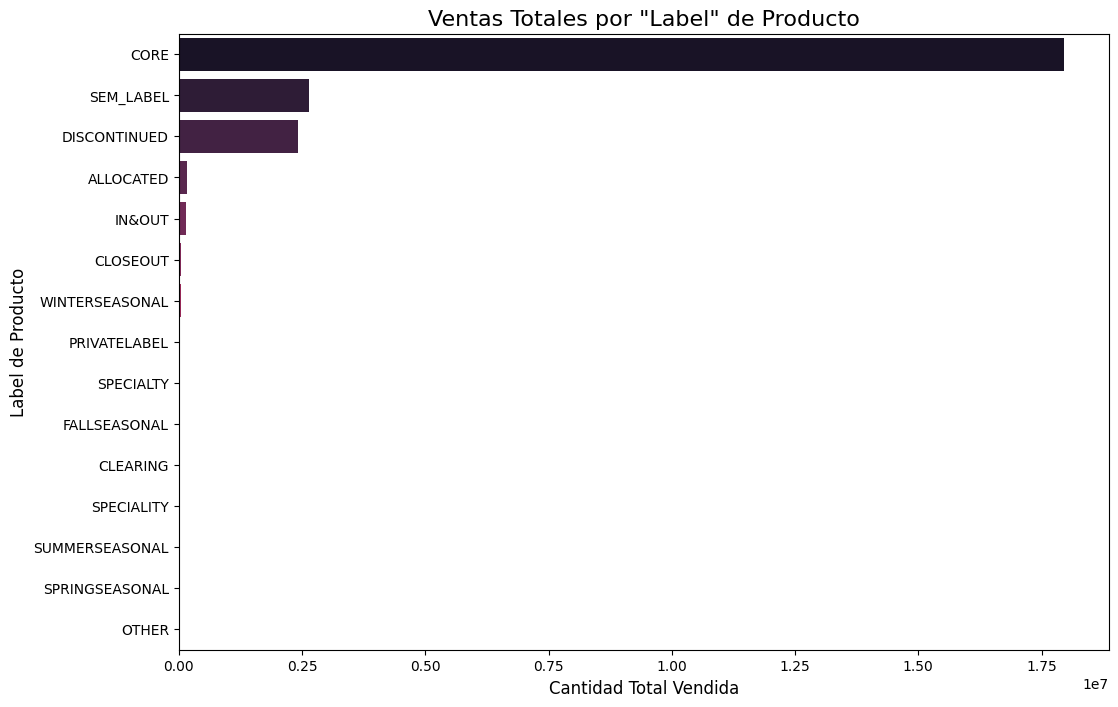

In [13]:
print("\nGenerando Gr√°fico 2: Ventas Totales por 'label' de Producto...")

# Agrupar por label, sumar la cantidad y ordenar
ventas_por_label = df_para_analisis.groupBy("label") \
    .agg(sum("quantity").alias("total_quantity")) \
    .orderBy(col("total_quantity").desc()) \
    .toPandas()

# Generar el gr√°fico
plt.figure(figsize=(12, 8))
sns.barplot(data=ventas_por_label, x="total_quantity", y="label", palette="rocket")
plt.title('Ventas Totales por "Label" de Producto', fontsize=16)
plt.xlabel('Cantidad Total Vendida', fontsize=12)
plt.ylabel('Label de Producto', fontsize=12)
plt.show()


Generando Gr√°fico 3: Ventas Semanales por 'label' de Producto...


/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


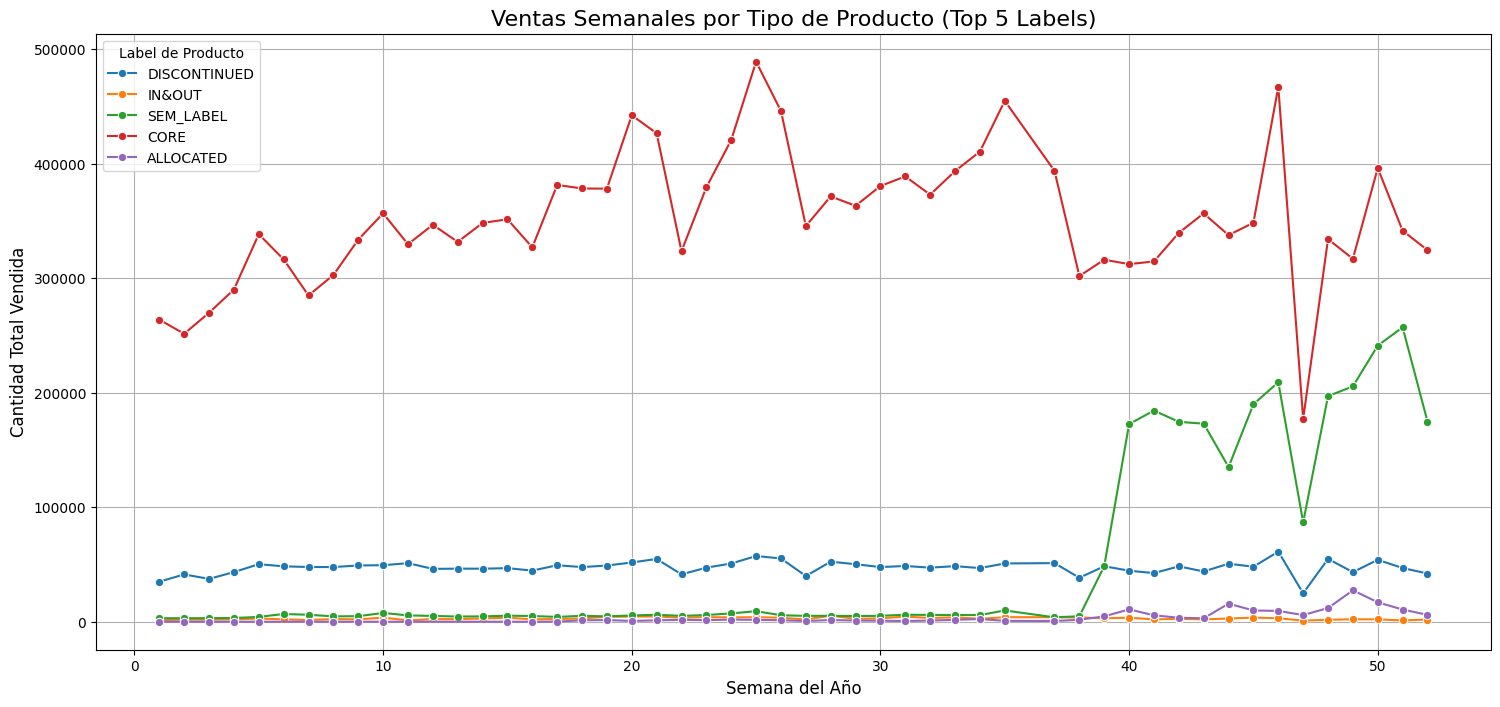

In [14]:
from pyspark.sql.functions import weekofyear

print("\nGenerando Gr√°fico 3: Ventas Semanales por 'label' de Producto...")

# Primero, identificamos los 5 labels m√°s importantes para no saturar el gr√°fico
top_labels = [row['label'] for row in df_para_analisis.groupBy('label').count().orderBy('count', ascending=False).limit(5).collect()]

# Filtramos y agregamos los datos
ventas_semanales_por_label = df_para_analisis.filter(col('label').isin(top_labels)) \
    .groupBy(weekofyear("transaction_date").alias("semana"), "label") \
    .agg(sum("quantity").alias("total_quantity")) \
    .orderBy("semana") \
    .toPandas()

# Generar el gr√°fico de l√≠neas m√∫ltiples
plt.figure(figsize=(18, 8))
sns.lineplot(data=ventas_semanales_por_label, x="semana", y="total_quantity", hue="label", marker="o", style="label", dashes=False)
plt.title('Ventas Semanales por Tipo de Producto (Top 5 Labels)', fontsize=16)
plt.xlabel('Semana del A√±o', fontsize=12)
plt.ylabel('Cantidad Total Vendida', fontsize=12)
plt.legend(title='Label de Producto')
plt.grid(True)
plt.show()

Generando Gr√°fico 1: Histograma de la columna 'quantity'...


/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


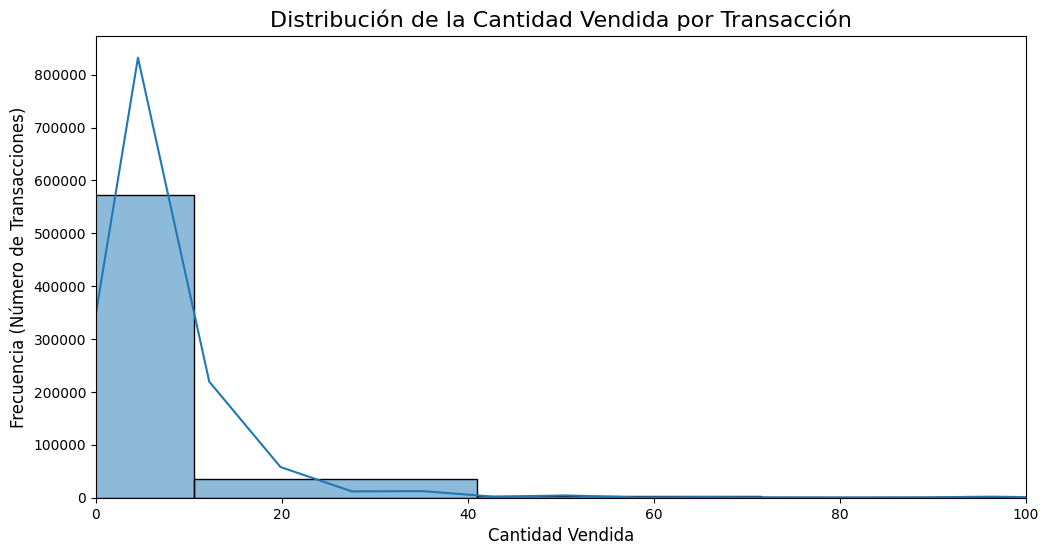

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Usaremos el DataFrame con los labels ya corregidos
df_para_analisis = df_filtrado_completo

print("Generando Gr√°fico 1: Histograma de la columna 'quantity'...")

# Tomamos una muestra del 10% de los datos para que el gr√°fico sea manejable
quantity_sample_df = df_para_analisis.select("quantity").sample(False, 0.1).toPandas()

# Generar el histograma
plt.figure(figsize=(12, 6))
# Usamos un rango y n√∫mero de bins para enfocarnos en las cantidades m√°s comunes
sns.histplot(data=quantity_sample_df, x="quantity", bins=50, kde=True)
plt.title('Distribuci√≥n de la Cantidad Vendida por Transacci√≥n', fontsize=16)
plt.xlabel('Cantidad Vendida', fontsize=12)
plt.ylabel('Frecuencia (N√∫mero de Transacciones)', fontsize=12)
# Ponemos un l√≠mite al eje x para ver mejor la distribuci√≥n principal, ya que hay valores at√≠picos muy grandes
plt.xlim(0, 100)
plt.show()


Generando Gr√°fico 2: Diagrama de Dispersi√≥n de 'discount' vs 'quantity'...


/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


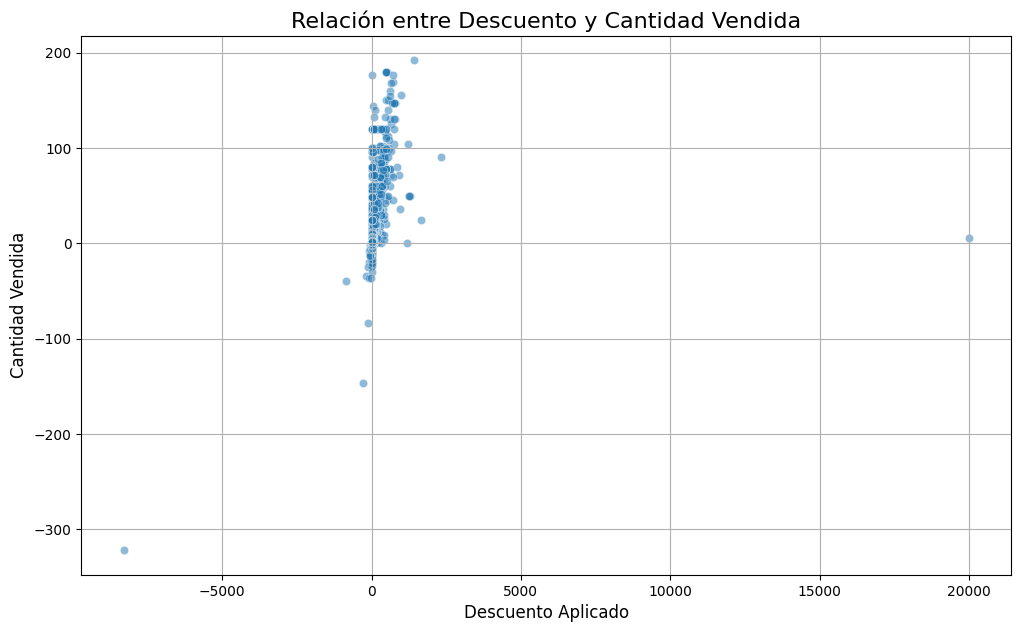

In [16]:
print("\nGenerando Gr√°fico 2: Diagrama de Dispersi√≥n de 'discount' vs 'quantity'...")

# Para un scatter plot, una muestra m√°s peque√±a (ej. 1%) es suficiente para ver la tendencia
# y evitamos que el gr√°fico se sature de puntos (overplotting).
# Tambi√©n filtramos cantidades muy grandes para que el gr√°fico sea legible.
sample_df = df_para_analisis.filter(col("quantity") < 200) \
    .select("discount", "quantity") \
    .sample(False, 0.01) \
    .toPandas()

# Generar el diagrama de dispersi√≥n
plt.figure(figsize=(12, 7))
sns.scatterplot(data=sample_df, x="discount", y="quantity", alpha=0.5)
plt.title('Relaci√≥n entre Descuento y Cantidad Vendida', fontsize=16)
plt.xlabel('Descuento Aplicado', fontsize=12)
plt.ylabel('Cantidad Vendida', fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
df_para_filtrar = df_para_analisis

print(f"N√∫mero de filas antes de filtrar devoluciones: {
df_para_filtrar.count()
}")

# Filtramos para quedarnos solo con las ventas reales, no nos interesan reembolsos (valores negativos)
df_modelo = df_para_filtrar.filter(
    (col("quantity") > 0) & 
    (col("discount") >= 0)
)

print(f"N√∫mero de filas despu√©s de filtrar devoluciones: {
df_modelo.count()
}")

N√∫mero de filas antes de filtrar devoluciones: 6139030


N√∫mero de filas despu√©s de filtrar devoluciones: 6015655


In [ ]:
total_rows = df_modelo.count()
print(f"El DataFrame 'df_modelo' tiene {total_rows} filas.")

# Calcular el porcentaje de nulos para cada columna
print("\nPorcentaje de valores nulos en 'df_modelo':")
df_modelo.select([
    (count(when(isnull(c), c)) / total_rows * 100).alias(c) 
    for c in df_modelo.columns
]).show()

El DataFrame 'df_modelo' tiene 6015655 filas.

Porcentaje de valores nulos en 'df_modelo':


+---+-------+--------------+----------------+--------------+--------+-----------+---------+------------+--------+-----+---------+---------+-----+-----+-----------------+-----+----------+-------+-------------+-------+
|pdv|produto|distributor_id|transaction_date|reference_date|quantity|gross_value|net_value|gross_profit|discount|taxes|categoria|descricao|tipos|label|     subcategoria|marca|fabricante|premise|categoria_pdv|zipcode|
+---+-------+--------------+----------------+--------------+--------+-----------+---------+------------+--------+-----+---------+---------+-----+-----+-----------------+-----+----------+-------+-------------+-------+
|0.0|    0.0|           0.0|             0.0|           0.0|     0.0|        0.0|      0.0|         0.0|     0.0|  0.0|      0.0|      0.0|  0.0|  0.0|0.161728024629072|  0.0|       0.0|    0.0|          0.0|    0.0|
+---+-------+--------------+----------------+--------------+--------+-----------+---------+------------+--------+-----+---------+---

In [20]:
print(f"N√∫mero de filas en df_modelo (antes): {
df_modelo.count()
}")

# Eliminar cualquier fila que contenga al menos un valor nulo
df_final = df_modelo.dropna()

print(f"N√∫mero de filas en df_final (despu√©s): {
df_final.count()
}")

N√∫mero de filas en df_modelo (antes): 6015655


N√∫mero de filas en df_final (despu√©s): 6005926


/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Iniciando la generaci√≥n de gr√°ficos de validaci√≥n...
Generando: Gr√°fico de L√≠neas de Ventas Semanales...


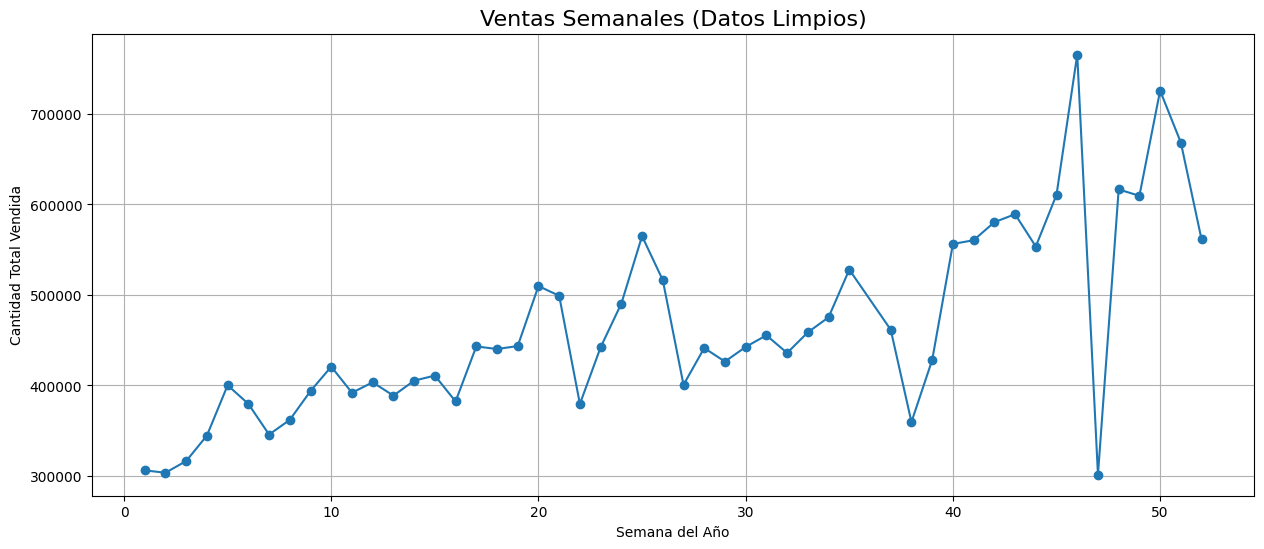

Generando: Box Plot de Ventas por D√≠a de la Semana...


/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


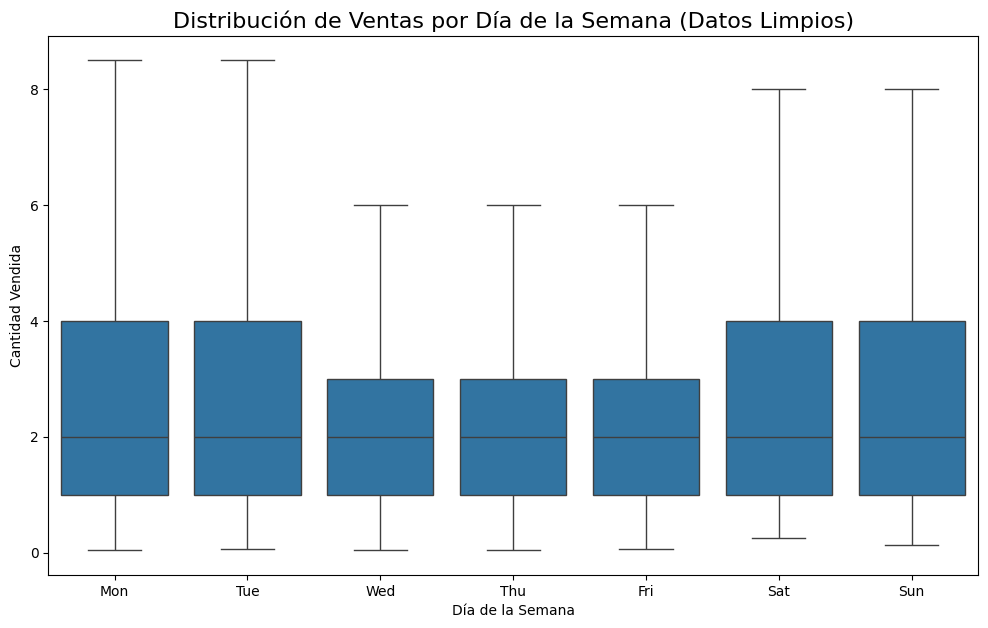

Generando: Top 10 Categor√≠as de Producto...


/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/tmp/ipykernel_5031/3223611270.py:44: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_categorias, x="total_q", y="categoria", palette="mako")


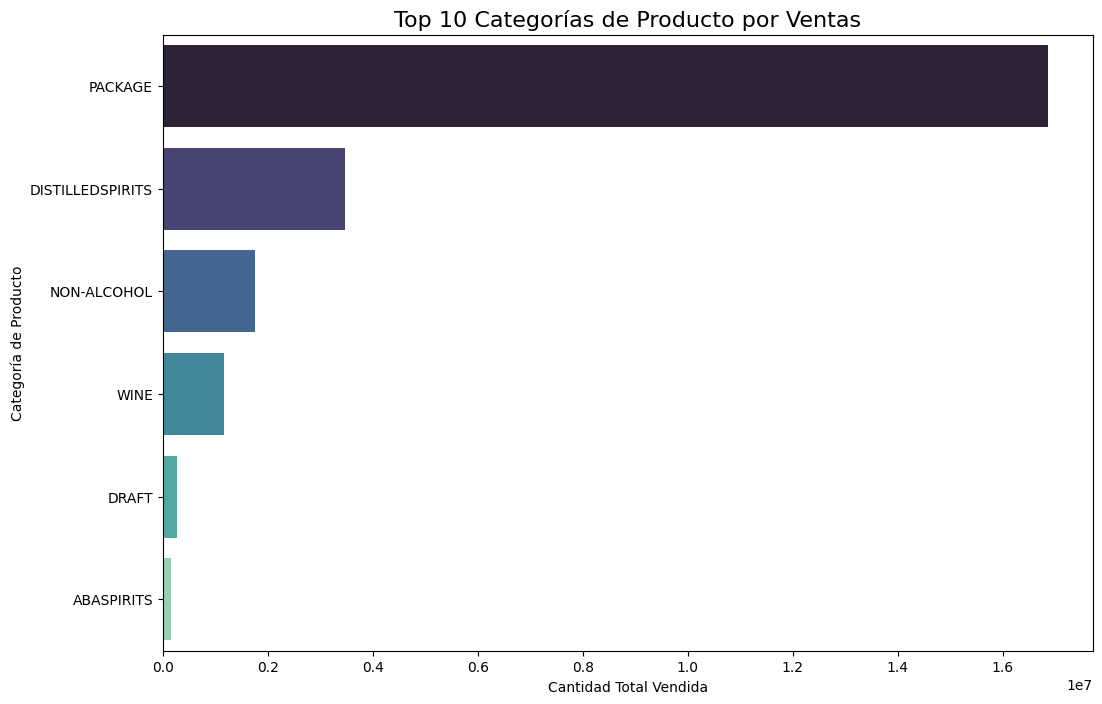

/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Generando: Gr√°fico de Barras por 'label' de Producto...


/tmp/ipykernel_5031/3223611270.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ventas_por_label, x="total_q", y="label", palette="rocket")


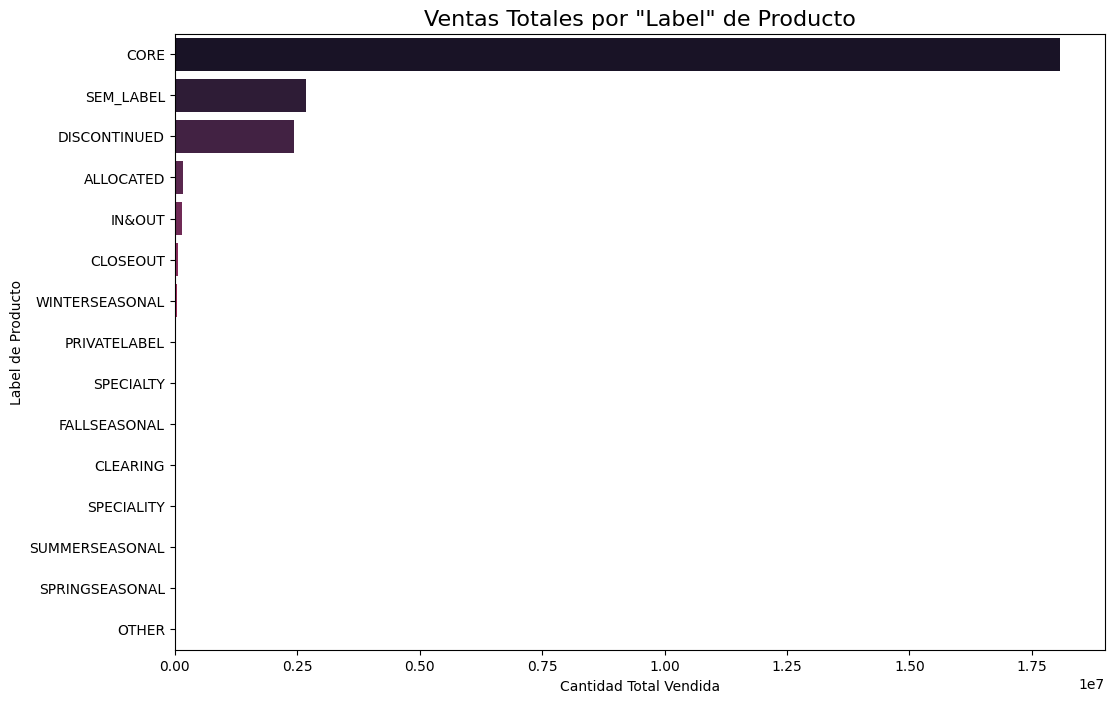

Generando: Gr√°fico de L√≠neas por 'label' Principal...


/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


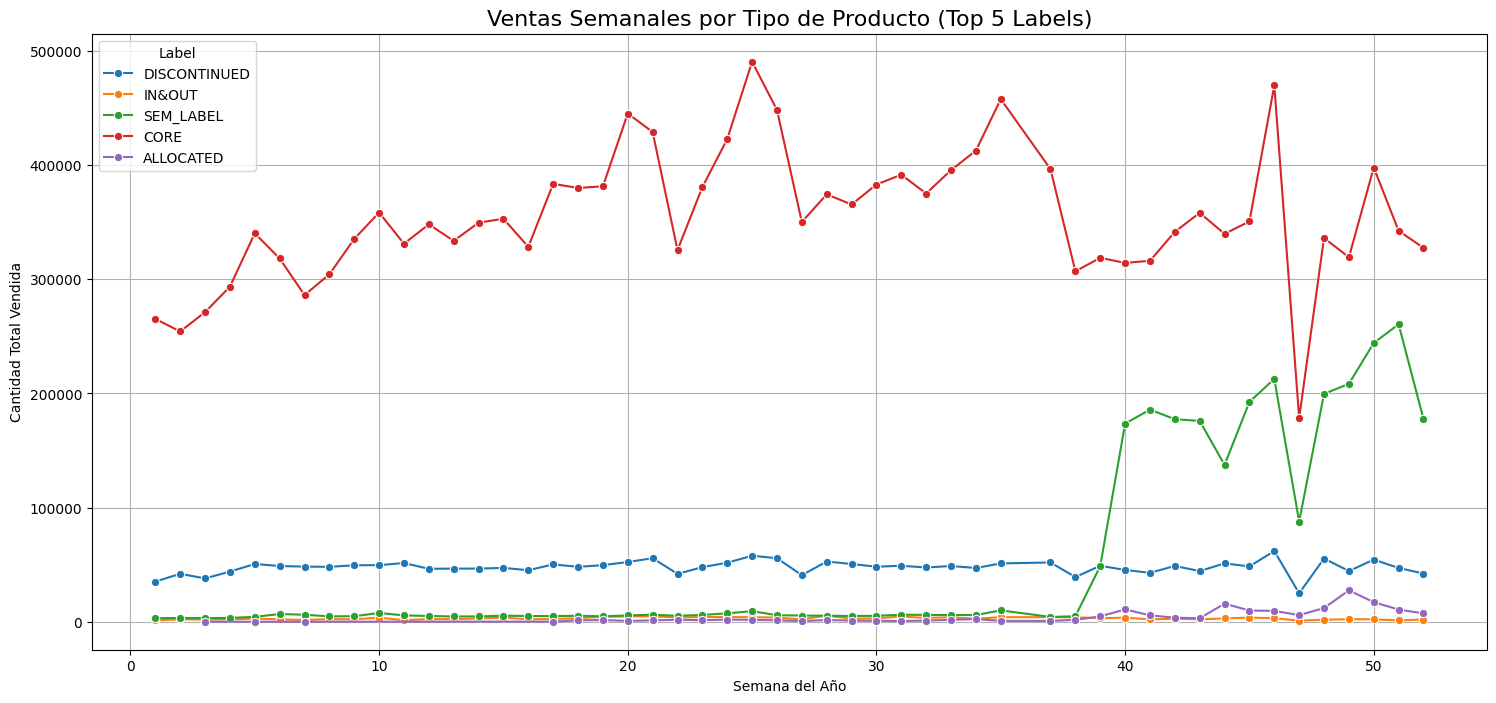

Generando: Top 10 Categor√≠as de PDV...


/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/tmp/ipykernel_5031/3223611270.py:78: FutureWarning:                            

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_pdv, x="total_q", y="categoria_pdv", palette="viridis")


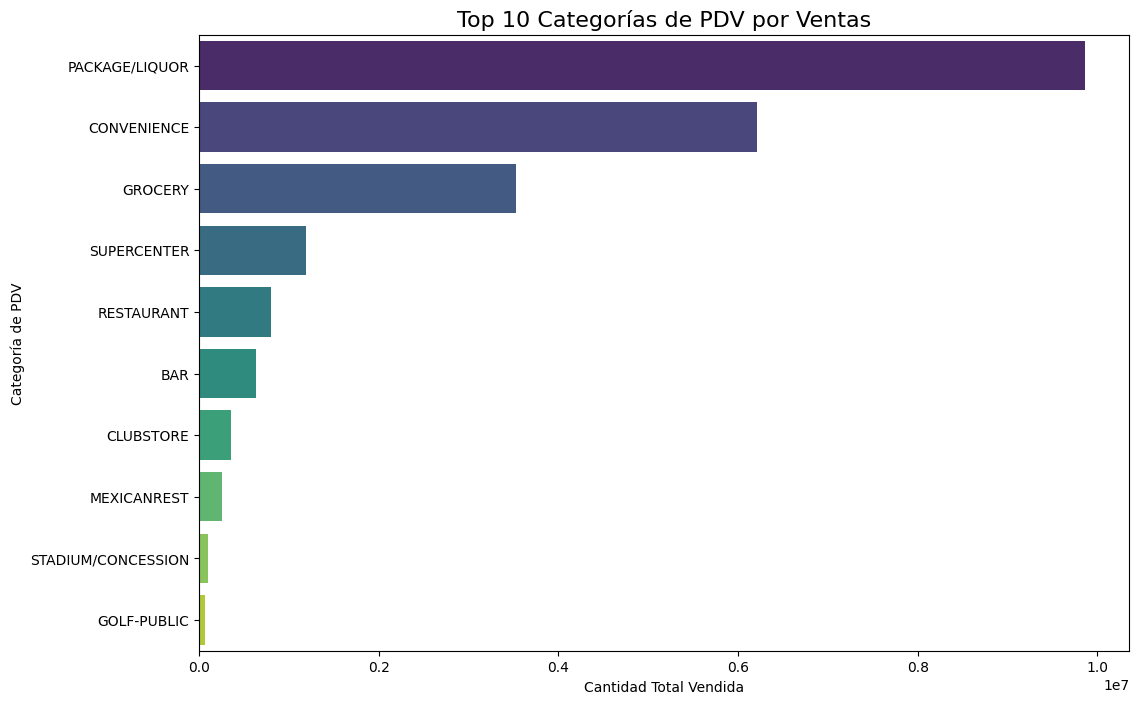

/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Generando: Gr√°fico de Barras por 'premise'...


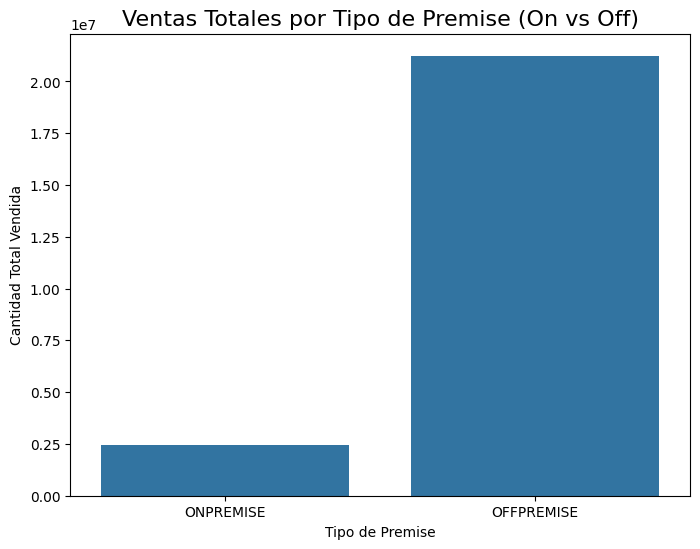

Generando: Histograma de 'quantity'...


/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


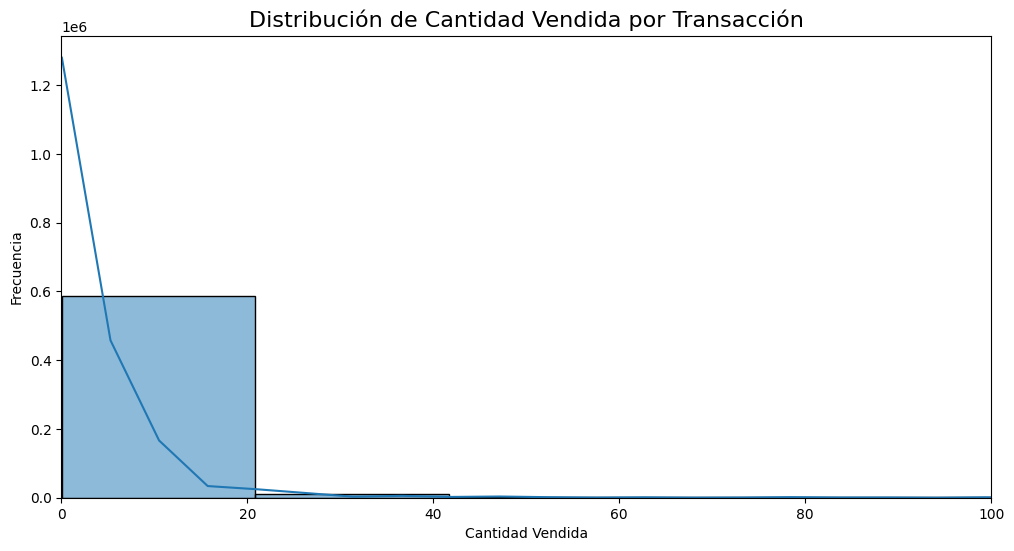

Generando: Diagrama de Dispersi√≥n 'discount' vs 'quantity'...


/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


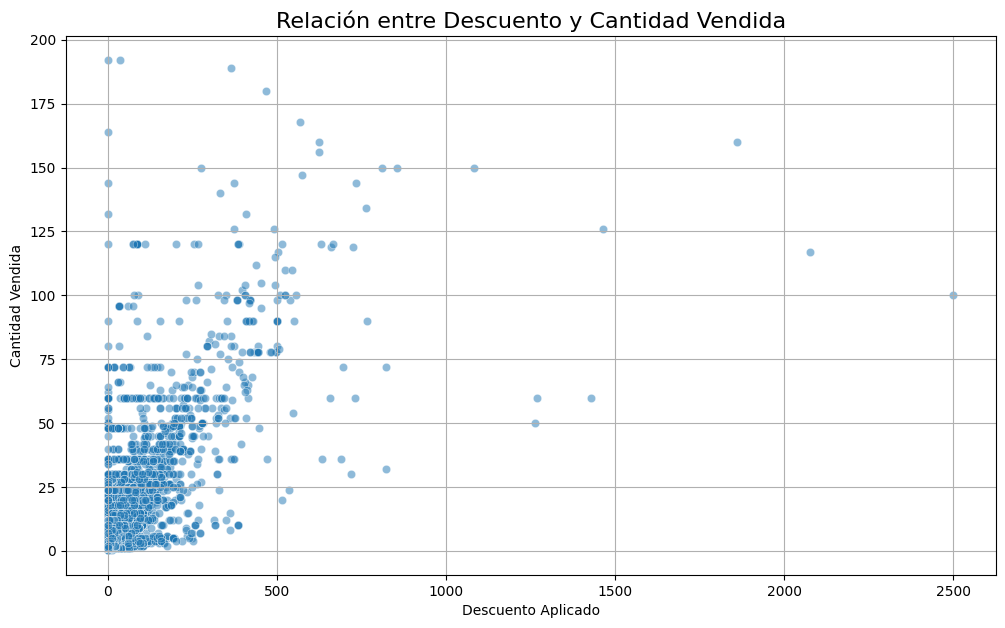


¬°Todos los gr√°ficos de validaci√≥n han sido generados!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, sum, weekofyear, month, date_format

df_para_graficos = df_final
df_para_graficos.cache() # Cachear para acelerar las operaciones repetidas

print("Iniciando la generaci√≥n de gr√°ficos de validaci√≥n...")

# --- An√°lisis de Series Temporales (¬øCu√°ndo vendemos?) üìà ---

## Gr√°fico de L√≠neas de Ventas Semanales
print("Generando: Gr√°fico de L√≠neas de Ventas Semanales...")
ventas_semanales = df_para_graficos.groupBy(weekofyear("transaction_date").alias("semana")) \
    .agg(sum("quantity").alias("total_quantity")) \
    .orderBy("semana").toPandas()

plt.figure(figsize=(15, 6))
plt.plot(ventas_semanales['semana'], ventas_semanales['total_quantity'], marker='o', linestyle='-')
plt.title('Ventas Semanales (Datos Limpios)', fontsize=16)
plt.xlabel('Semana del A√±o'); plt.ylabel('Cantidad Total Vendida'); plt.grid(True); plt.show()

## Box Plot de Ventas por D√≠a de la Semana
print("Generando: Box Plot de Ventas por D√≠a de la Semana...")
ventas_por_dia = df_para_graficos.withColumn("dia_semana", date_format("transaction_date", "E")) \
    .select("dia_semana", "quantity").toPandas()

plt.figure(figsize=(12, 7))
dias_ordenados = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
sns.boxplot(data=ventas_por_dia, x="dia_semana", y="quantity", order=dias_ordenados, showfliers=False)
plt.title('Distribuci√≥n de Ventas por D√≠a de la Semana (Datos Limpios)', fontsize=16)
plt.xlabel('D√≠a de la Semana'); plt.ylabel('Cantidad Vendida'); plt.show()

# --- An√°lisis por Producto (¬øQu√© vendemos?) üõçÔ∏è ---

## Gr√°fico de Barras Horizontales del Top 10 de Categor√≠as
print("Generando: Top 10 Categor√≠as de Producto...")
top_10_categorias = df_para_graficos.groupBy("categoria").agg(sum("quantity").alias("total_q")) \
    .orderBy(col("total_q").desc()).limit(10).toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_categorias, x="total_q", y="categoria", palette="mako")
plt.title('Top 10 Categor√≠as de Producto por Ventas', fontsize=16)
plt.xlabel('Cantidad Total Vendida'); plt.ylabel('Categor√≠a de Producto'); plt.show()

## Gr√°fico de Barras por label de Producto
print("Generando: Gr√°fico de Barras por 'label' de Producto...")
ventas_por_label = df_para_graficos.groupBy("label").agg(sum("quantity").alias("total_q")) \
    .orderBy(col("total_q").desc()).toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(data=ventas_por_label, x="total_q", y="label", palette="rocket")
plt.title('Ventas Totales por "Label" de Producto', fontsize=16)
plt.xlabel('Cantidad Total Vendida'); plt.ylabel('Label de Producto'); plt.show()

## Gr√°fico de L√≠neas de Ventas por label Principal
print("Generando: Gr√°fico de L√≠neas por 'label' Principal...")
top_labels = [row['label'] for row in df_para_graficos.groupBy('label').count().orderBy('count', ascending=False).limit(5).collect()]
ventas_semanales_por_label = df_para_graficos.filter(col('label').isin(top_labels)) \
    .groupBy(weekofyear("transaction_date").alias("semana"), "label") \
    .agg(sum("quantity").alias("total_q")).orderBy("semana").toPandas()

plt.figure(figsize=(18, 8))
sns.lineplot(data=ventas_semanales_por_label, x="semana", y="total_q", hue="label", marker="o", style="label", dashes=False)
plt.title('Ventas Semanales por Tipo de Producto (Top 5 Labels)', fontsize=16)
plt.xlabel('Semana del A√±o'); plt.ylabel('Cantidad Total Vendida'); plt.legend(title='Label'); plt.grid(True); plt.show()

# --- An√°lisis por Punto de Venta (¬øD√≥nde vendemos?) üè™ ---

## Gr√°fico de Barras Horizontales del Top 10 de categoria_pdv
print("Generando: Top 10 Categor√≠as de PDV...")
top_10_pdv = df_para_graficos.groupBy("categoria_pdv").agg(sum("quantity").alias("total_q")) \
    .orderBy(col("total_q").desc()).limit(10).toPandas()

plt.figure(figsize=(12, 8))
sns.barplot(data=top_10_pdv, x="total_q", y="categoria_pdv", palette="viridis")
plt.title('Top 10 Categor√≠as de PDV por Ventas', fontsize=16)
plt.xlabel('Cantidad Total Vendida'); plt.ylabel('Categor√≠a de PDV'); plt.show()

## Gr√°fico de Barras por premise (On/Off Premise)
print("Generando: Gr√°fico de Barras por 'premise'...")
ventas_por_premise = df_para_graficos.groupBy("premise").agg(sum("quantity").alias("total_q")).toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(data=ventas_por_premise, x="premise", y="total_q")
plt.title('Ventas Totales por Tipo de Premise (On vs Off)', fontsize=16)
plt.xlabel('Tipo de Premise'); plt.ylabel('Cantidad Total Vendida'); plt.show()

# --- An√°lisis de Relaciones y Distribuciones üìä ---

## Histograma de la quantity por Transacci√≥n
print("Generando: Histograma de 'quantity'...")
quantity_sample = df_para_graficos.select("quantity").sample(False, 0.1).toPandas()

plt.figure(figsize=(12, 6))
sns.histplot(data=quantity_sample, x="quantity", bins=50, kde=True)
plt.title('Distribuci√≥n de Cantidad Vendida por Transacci√≥n', fontsize=16)
plt.xlabel('Cantidad Vendida'); plt.ylabel('Frecuencia'); plt.xlim(0, 100); plt.show()

## Diagrama de Dispersi√≥n de discount vs. quantity
print("Generando: Diagrama de Dispersi√≥n 'discount' vs 'quantity'...")
scatter_sample = df_para_graficos.filter(col("quantity") < 200) \
    .select("discount", "quantity").sample(False, 0.01).toPandas()

plt.figure(figsize=(12, 7))
sns.scatterplot(data=scatter_sample, x="discount", y="quantity", alpha=0.5)
plt.title('Relaci√≥n entre Descuento y Cantidad Vendida', fontsize=16)
plt.xlabel('Descuento Aplicado'); plt.ylabel('Cantidad Vendida'); plt.grid(True); plt.show()

# Liberar la memoria cach√©
df_para_graficos.unpersist()
print("\n¬°Todos los gr√°ficos de validaci√≥n han sido generados!")

In [ ]:
base_path = "/home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/"
# --- GUARDAR DATOS EN CAPA SILVER ---
silver_path = f"{base_path}silver/datos_limpios"

print(f"Guardando DataFrame limpio en: {silver_path}")

# Usamos repartition(1) para guardar como un √∫nico archivo Parquet, ideal para esta etapa
df_final.repartition(1).write.mode("overwrite").parquet(silver_path)

print("¬°Datos guardados exitosamente en la capa Silver!")

Guardando DataFrame limpio en: /home/quind/GIT/Desafio-Tecnico-Hackathon-Forecast-Big-Data-2025/silver/datos_limpios


¬°Datos guardados exitosamente en la capa Silver!


In [3]:
spark.stop()